# Data Loading

In [176]:
import pandas as pd
import numpy as np

def read_users():
    users = {}
    chunks = pd.read_json("./yelp_dataset/yelp_academic_dataset_user.json", lines = True, chunksize = 10000)
    for chunk in chunks:
        for index, row in chunk.iterrows():
            users[row['user_id']] = row
    return users        
users = read_users()

In [103]:
from collections import defaultdict
from dateutil import parser

def get_reviews():
    review_map = defaultdict(list)
    average_ratings = defaultdict(list)
    chunks = pd.read_json("./yelp_dataset/yelp_academic_dataset_review.json", lines = True, chunksize = 3000)
    for chunk in chunks:
        for index, row in chunk.iterrows():
            bid = row["business_id"]
            review_map[row['user_id']].append((row["date"], row["stars"], bid))
            average_ratings[bid].append(int(row["stars"]))
    final_average_ratings = {}
    for b in average_ratings.keys():
        final_average_ratings[b] = np.mean(average_ratings[b])
    return final_average_ratings, review_map
    
final_average_ratings, review_map = get_reviews()

In [406]:
from sklearn.preprocessing import OneHotEncoder

def get_category_encoder():
    chunks = pd.read_json("./yelp_dataset/yelp_academic_dataset_business.json", lines = True, chunksize = 10000)
    ohv_training = []
    for chunk in chunks:
        for index, row in chunk.iterrows():
            try:
                array = [""] * 5
                a = row["categories"].split(', ')
                for i in range(min(5, len(a))):
                    array[i] = a[i]
                ohv_training.append(array)
            except AttributeError:
                continue
    enc = OneHotEncoder(handle_unknown="ignore")
    enc.fit(ohv_training)
    return enc

In [407]:
enc = get_category_encoder()

In [52]:
def get_business_map():
    business_map = {}
    chunks = pd.read_json("./yelp_dataset/yelp_academic_dataset_business.json", lines = True, chunksize = 3000)
    for chunk in chunks:
        for index, row in chunk.iterrows():
            business_map[row["business_id"]] = row
    return business_map
business_map = get_business_map()

In [104]:
import pickle

def dump_var(var, filename):
    with open(filename, "wb") as f:
        pickle.dump(var, f)

def load_var(filename):
    return pickle.loads(filename)
dump_var(review_map, "review_map.pkl")
# dump_var(business_map, "business_map.pkl")
dump_var(final_average_ratings, "final_average_ratings.pkl")

In [177]:
dump_var(users, "user_map.pkl")

## Dataset Analysis

/var/folders/qk/l24kr0vd3w1ccfx8ng5tp3l00000gr/T/ipykernel_9693/478392250.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


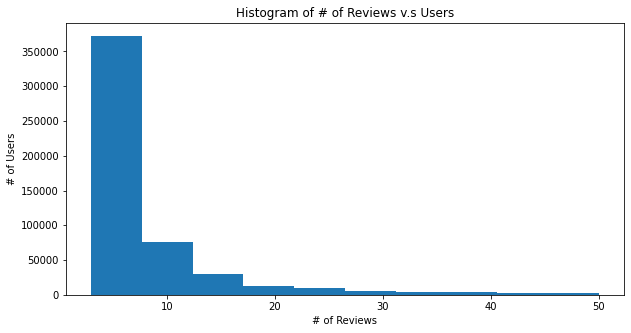

In [287]:
import matplotlib.pyplot as plt
n = []
fig, ax = plt.subplots(figsize = (10 ,5))
for key, value in review_map.items():
    n.append(len(value))
ax.hist(n, range = (3, 50))
ax.set_title("Histogram of # of Reviews v.s Users")
ax.set_ylabel("# of Users")
ax.set_xlabel("# of Reviews")
fig.show()

In [111]:
print(len(business_map) ** 3)

3398408913621736


In [281]:
len(business_map) 

150346

In [284]:
len(users)

1987897

In [296]:
len(review_map)

1987929

In [112]:
state_generator = lambda s : (s[0][-1], s[1][-1], s[2][-1])
state_distribution = defaultdict(int)

total = 0
for k, v in review_map.items():
    if len(v) < 3:
        continue
    v.sort()
    for i in range(len(v) - 2):
        s = state_generator(v[i: i + 3])
        total += 1
        state_distribution[s] += 1
for k in state_distribution.keys():
    state_distribution[k] = state_distribution[k] / total

In [291]:
len(state_distribution)

4144461

## Generate Data Points

In [164]:
def true_q_func(sequence, gamma = 0.5):
    reward = np.sum([(gamma ** i) * int(v[1]) for i, v in enumerate(sequence)])
    return reward

In [165]:
def create_data_points():
    data_points = [] # (user, last three events, action), q_value
    for user, reviews in review_map.items():
        reviews.sort()
        state = (0,0,0)
        for i, review in enumerate(reviews):
            q_value = true_q_func(reviews[i:])
            data_points.append(((user, state, review[-1]), q_value))
            state = (state[1], state[2], review[-1])
    return data_points
data_points = create_data_points()

In [169]:
dump_var(data_points, "data_points.pkl")

## State Engineering + Regression

## User Only, User and Business
Generating states from hand-picked items.

In [299]:
def user_only(user_id, state, action_taken):
    user = users[user_id]
    compliment_data = user.filter(regex="compliment*")
    v = compliment_data.to_numpy(dtype = int)
    return np.concatenate((v, [int(user["review_count"]), float(user["average_stars"]), len(user["friends"])]))

def user_and_business(user_id, state, action_taken):
    user = users[user_id]
    business = business_map[action_taken]
    user_vec = user_only(user_id, state, action_taken)
    business_vec = np.array([business["stars"], business["review_count"], business["is_open"]], dtype = float)
    return np.concatenate((user_vec, business_vec))
    
def user_and_business_abbreviate_history(user_id, state, action_taken):
    user = users[user_id]
    business = business_map[action_taken]
    print(user)
    print(business)
    
def generate_regression_dataset(f, num_points, dataset):
    x_array = []
    y_array = []
    if num_points >= 0:
        dataset_indices = np.random.choice(dataset.shape[0], size = num_points, replace = True) 
    else:
        dataset_indices = np.arange(dataset.shape[0])
    for dp in dataset[dataset_indices]:
        try:
            q_value = dp[1]
            x = f(*dp[0])
            x_array.append(x)
            y_array.append(q_value)
        except KeyError as e:
            print('KeyError: ', e)
            continue
    return x_array, y_array

In [300]:
a, b = generate_regression_dataset(user_and_business_abbreviate_history, 1, np.array(data_points, dtype=object))

user_id                                          Cvi8nZTwDVaQkqmmgQwQMw
name                                                              Diana
review_count                                                        320
yelping_since                                       2010-11-04 15:16:49
useful                                                              505
funny                                                               137
cool                                                                235
elite                                     2012,2013,2014,2015,2016,2017
friends               AVEJb-lCEY_WPExMoBr65g, wWyR5AdkPNwxEBZhYCGiFA...
fans                                                                 28
average_stars                                                      4.05
compliment_hot                                                       26
compliment_more                                                       2
compliment_profile                                              

### Dataset Generation

In [245]:
test_x_u, test_y_u = generate_regression_dataset(user_only, -1, np.array(data_points, dtype=object))

KeyError:  'tquAg8GqbhN5k6Hkd23M0A'
KeyError:  '5iBVQ3OeK8lV4Z_4PXc1Xw'
KeyError:  'u8cq-5zzD7dPSa3LR8rIMw'
KeyError:  '433BzxUeQAmRmK0g06UAfA'
KeyError:  'dWZlWFtsEXFVq_vulT00lA'
KeyError:  'sxxnBQb15fOyg30JInIKqw'
KeyError:  'MaengE6zJ6k_d5e6nwnVaA'
KeyError:  '5XiPz5mJK_RtJQVkXIqxYg'
KeyError:  'I200IyE9DCxJvvof2wnO6A'
KeyError:  'G0PWeUgNeGDobntevJlJ1g'
KeyError:  '0oMk8hhMqiSt4G1BJjjG6g'
KeyError:  'vq2H7lJ73VwXMDqC8DiImw'
KeyError:  'lzpM_Vf2rKA4ivGtAIOH4w'
KeyError:  'lzpM_Vf2rKA4ivGtAIOH4w'
KeyError:  'qH_QwXBgA4Z7WyCjtwRi2A'
KeyError:  '3N6-acEgosQSbipmBZKoSg'
KeyError:  'ufZfni7nb_KdJC6DXNfVHQ'
KeyError:  'VTfl9PALOCiGV8SUBpCZEQ'
KeyError:  'UwaRBUSj45sE9_kAnaGggw'
KeyError:  'AQnEwfNAgdxqRWpia__syA'
KeyError:  '77n3enAMdlka0pZ82GT9VQ'
KeyError:  'NCeW1I6C4K7qhY4kRH8cOA'
KeyError:  'I6tb6vPxJ8Tct79JgqIDrQ'
KeyError:  'U76IFozArZsShdmoIdDMUw'
KeyError:  'QLU-88WwG4hKj6jKSR8iig'
KeyError:  'EkUWydx3bJmiMWOBmdVf4Q'
KeyError:  'OxvEeexqWWeWkPwkKtTy2Q'
KeyError:  '5-L9Oo6PyUiBjeqj

In [270]:
test_x_ub, test_y_ub = generate_regression_dataset(user_and_business, -1, np.array(data_points, dtype=object))

KeyError:  'tquAg8GqbhN5k6Hkd23M0A'
KeyError:  '5iBVQ3OeK8lV4Z_4PXc1Xw'
KeyError:  'u8cq-5zzD7dPSa3LR8rIMw'
KeyError:  '433BzxUeQAmRmK0g06UAfA'
KeyError:  'dWZlWFtsEXFVq_vulT00lA'
KeyError:  'sxxnBQb15fOyg30JInIKqw'
KeyError:  'MaengE6zJ6k_d5e6nwnVaA'
KeyError:  '5XiPz5mJK_RtJQVkXIqxYg'
KeyError:  'I200IyE9DCxJvvof2wnO6A'
KeyError:  'G0PWeUgNeGDobntevJlJ1g'
KeyError:  '0oMk8hhMqiSt4G1BJjjG6g'
KeyError:  'vq2H7lJ73VwXMDqC8DiImw'
KeyError:  'lzpM_Vf2rKA4ivGtAIOH4w'
KeyError:  'lzpM_Vf2rKA4ivGtAIOH4w'
KeyError:  'qH_QwXBgA4Z7WyCjtwRi2A'
KeyError:  '3N6-acEgosQSbipmBZKoSg'
KeyError:  'ufZfni7nb_KdJC6DXNfVHQ'
KeyError:  'VTfl9PALOCiGV8SUBpCZEQ'
KeyError:  'UwaRBUSj45sE9_kAnaGggw'
KeyError:  'AQnEwfNAgdxqRWpia__syA'
KeyError:  '77n3enAMdlka0pZ82GT9VQ'
KeyError:  'NCeW1I6C4K7qhY4kRH8cOA'
KeyError:  'I6tb6vPxJ8Tct79JgqIDrQ'
KeyError:  'U76IFozArZsShdmoIdDMUw'
KeyError:  'QLU-88WwG4hKj6jKSR8iig'
KeyError:  'EkUWydx3bJmiMWOBmdVf4Q'
KeyError:  'OxvEeexqWWeWkPwkKtTy2Q'
KeyError:  '5-L9Oo6PyUiBjeqj

### Linear Regression

In [263]:
from sklearn.linear_model import LinearRegression

x, y = generate_regression_dataset(user_only, 400000, np.array(data_points, dtype=object))

KeyError:  'OxvEeexqWWeWkPwkKtTy2Q'
KeyError:  'EkUWydx3bJmiMWOBmdVf4Q'


In [264]:
x2, y2 = generate_regression_dataset(user_and_business, 400000, np.array(data_points, dtype=object))

KeyError:  'QLU-88WwG4hKj6jKSR8iig'
KeyError:  'vq2H7lJ73VwXMDqC8DiImw'


In [267]:
from sklearn.tree import DecisionTreeRegressor

reg = LinearRegression().fit(x,y)

linreg_score = reg.score(test_x_u, test_y_u)
print('Lin reg score:', linreg_score)
mean_absolute_error(reg.predict(test_x_u), test_y_u)

Lin reg score: 0.3089016218625674


1.722623391175773

In [301]:
reg2 = LinearRegression().fit(x2,y2)
s = reg2.score(test_x_ub,test_y_ub)
print('Lin Reg 2', s)
mean_absolute_error(reg2.predict(test_x_ub), test_y_ub)

Lin Reg 2 0.3459687525794034


1.6703020357226976

## Decision Tree Regression

In [320]:
treeReg = DecisionTreeRegressor().fit(x,y)
treereg_score = treeReg.score(test_x_u, test_y_u)
print('Tree reg score:', treereg_score)
mean_absolute_error(treeReg.predict(test_x_u), test_y_u)

Tree reg score: 0.22462280173713833


1.6041770380986538

In [323]:
treeReg2 = DecisionTreeRegressor().fit(x2,y2)
treereg_score = treeReg2.score(test_x_ub, test_y_ub)
print('Tree reg score:', treereg_score)
mean_absolute_error(treeReg2.predict(test_x_ub), test_y_ub)

Tree reg score: 0.05497401713745864


1.7392769266569104

In [325]:
from sklearn.ensemble import RandomForestRegressor

treeReg3 = RandomForestRegressor().fit(x2,y2)
treereg_score = treeReg3.score(test_x_ub, test_y_ub)
print('Random Tree reg score:', treereg_score)
mean_absolute_error(treeReg3.predict(test_x_ub), test_y_ub)

Random Tree reg score: 0.4950274063402891


1.3512694668053373

In [321]:
treeReg.feature_importances_

array([0.01427906, 0.01375113, 0.00616916, 0.0042099 , 0.0016324 ,
       0.02101875, 0.02840724, 0.01811108, 0.01012584, 0.01545495,
       0.01211113, 0.18947184, 0.53961843, 0.12563908])

In [324]:
treeReg2.feature_importances_

array([0.01088137, 0.01020569, 0.00473967, 0.00317507, 0.00164074,
       0.02331206, 0.02182258, 0.01511193, 0.00837274, 0.01423636,
       0.00990511, 0.14490454, 0.42605763, 0.0822165 , 0.05426982,
       0.15773578, 0.01141241])

In [326]:
treeReg3.feature_importances_

array([0.0110657 , 0.01025578, 0.00485753, 0.00333844, 0.00160552,
       0.02640314, 0.02145573, 0.01000339, 0.01022368, 0.01408996,
       0.009931  , 0.14791361, 0.42758416, 0.08109265, 0.05593868,
       0.15315574, 0.0110853 ])

/var/folders/qk/l24kr0vd3w1ccfx8ng5tp3l00000gr/T/ipykernel_9693/1763310551.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


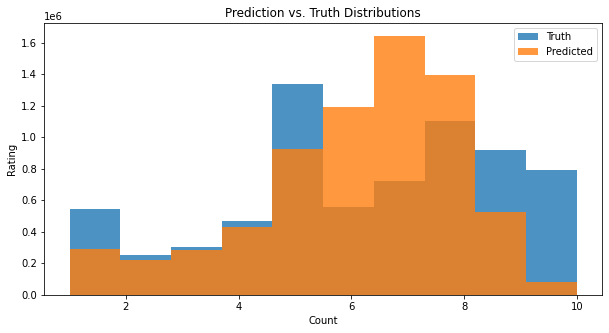

In [328]:
fig, ax = plt.subplots(figsize=(10,5))
ax.hist(test_y_ub, alpha = 0.8, label = "Truth")
ax.hist(treeReg3.predict(test_x_ub), alpha = 0.8, label = "Predicted")
ax.set_title("Prediction vs. Truth Distributions")
ax.set_xlabel("Count")
ax.set_ylabel("Rating")
ax.legend()
fig.show()

In [316]:
a = np.array(test_y_u)
np.sum(np.abs(a - np.mean(a))) / a.shape[0]

2.079455566227805